In [27]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import torch.nn.functional as F
import dgl
import os.path as osp
import GCL.losses as L
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam
from GCL.eval import get_split, LREvaluator, SVMEvaluator
from GCL.models import SingleBranchContrast

from scipy.io import loadmat
from GCL.models.contrast_model import WithinEmbedContrast
from GCL.models import contrast_model
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics


In [28]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair

class MyGATConv(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 num_heads,
                 feat_drop=0.5,
                 attn_drop=0.5,
                 alpha=0.1,
                 negative_slope=0.05,
                 residual=True,
                 activation=None,
                 allow_zero_in_degree=False,
                 bias=True,
                 use_symmetric_norm=False
                 ):
        super(MyGATConv, self).__init__()
        self._num_heads = num_heads
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._allow_zero_in_degree = allow_zero_in_degree
        self._use_symmetric_norm = use_symmetric_norm
        self._residual = residual
        if isinstance(in_feats, tuple):
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
            self.fc_dst = nn.Linear(
                self._in_dst_feats, out_feats * num_heads, bias=False)
        else:
            self.fc = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
        self.attn_l = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feats)))
        self.attn_r = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feats)))
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.alpha = alpha
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_feats,)))
        else:
            self.register_buffer('bias', None)
        if residual:
            self.res_fc = nn.Linear(
                self._in_dst_feats, num_heads * out_feats, bias=False)
        else:
            self.register_buffer('res_fc', None)
        self.reset_parameters()
        self.activation = activation

        # edge_feats = out_feats
        # self._edge_feats = edge_feats
        # num_etypes = 4
        # self.fc_edge = nn.Linear(
        #     edge_feats, edge_feats * num_heads, bias=True)
        # self.edge_emb = nn.Embedding(num_etypes, edge_feats)

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        if hasattr(self, 'fc'):
            nn.init.xavier_normal_(self.fc.weight, gain=gain)
        else:
            nn.init.xavier_normal_(self.fc_src.weight, gain=gain)
            nn.init.xavier_normal_(self.fc_dst.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_l, gain=gain)
        nn.init.xavier_normal_(self.attn_r, gain=gain)
        nn.init.constant_(self.bias, 0)
        if isinstance(self.res_fc, nn.Linear):
            nn.init.xavier_normal_(self.res_fc.weight, gain=gain)

    def forward(self, graph, feat, res_attn=None):
        with graph.local_scope():
            h_src = h_dst = self.feat_drop(feat)
            feat_src = feat_dst = self.fc(h_src).view(
                -1, self._num_heads, self._out_feats)
            if graph.is_block:
                feat_dst = feat_src[:graph.number_of_dst_nodes()]

            if self._use_symmetric_norm:
                degs = graph.out_degrees().float().clamp(min=1)
                norm = torch.pow(degs, -0.5)
                shp = norm.shape + (1,) * (feat_src.dim() - 1)
                norm = torch.reshape(norm, shp)
                feat_src = feat_src * norm

            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            graph.srcdata.update({'ft': feat_src, 'el': el})
            graph.dstdata.update({'er': er})
            # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
            graph.apply_edges(fn.u_add_v('el', 'er', 'e'))
            e = self.leaky_relu(graph.edata.pop('e'))
            if res_attn is not None:
                e = e * (1 - self.alpha) + res_attn * self.alpha

            # e = e.masked_fill(e < 0.05, 0)

            # graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            e = self.attn_drop(dglnn.edge_softmax(graph, e))
            graph.edata['a'] = e

            # message passing
            graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                             fn.sum('m', 'ft'))
            rst = graph.dstdata['ft']

            if self._use_symmetric_norm:
                degs = graph.out_degrees().float().clamp(min=1)
                norm = torch.pow(degs, -0.5)
                shp = norm.shape + (1,) * (feat_src.dim() - 1)
                norm = torch.reshape(norm, shp)
                rst = rst * norm
            # residual
            if self.res_fc is not None:
                resval = self.res_fc(h_dst).view(h_dst.shape[0], self._num_heads, self._out_feats)
                rst = rst + resval

            # bias
            if self.bias is not None:
                rst = rst + self.bias.view(1, self._num_heads, self._out_feats)
            # activation
            if self.activation:
                rst = self.activation(rst)

            return rst, graph.edata['a'].detach()

class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.SELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(num_heads * hidden_dim)
        self.layers = nn.ModuleList()
        self.layers.append(
            MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads, residual=False)
        )
        for _ in range(1, num_layers):
            self.layers.append(
                MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads, residual=False)
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph):
        z = x
        attn = None
        for i in range(self.num_layers):
            z, attn = self.layers[i](graph, z, attn)
            z = z.flatten(1)
            z = self.norm(z)
            z = self.act(z)
        z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z

class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()


        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads).to(device)

        # self.decoder = nn.Sequential(
        #     nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        #     nn.SELU(),
        #     nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        #     nn.SELU(),
        # )

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5

        # self.pe = dgl.laplacian_pe(graph, x.size(1)).to(device)

    def forward(self, x, graph, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        z = self.encoder(x, graph)
        # z = self.decoder(z)

        x1, edge_index1, _ = aug1(x, edge_index)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        z1 = self.encoder(x1, graph1)

        x2, edge_index2, _ = aug2(x, edge_index)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        z2 = self.encoder(x2, graph2)


        q = 1.0 / (1.0 + torch.sum(torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.v)
        q = q.pow((self.v + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()

        # qs.append(q)
        return z, z1, z2, q


In [29]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [30]:

device = torch.device('cuda')
path = osp.join(osp.pardir, 'datasets', 'ACM')


In [31]:
# edge_index = []
# for i in tqdm(range(len(mat['PLP']))):
#     for j in range(len(mat['PLP'])):
#         if mat['PAP'][i][j] == 1:
#             edge_index.append([i, j])

graph_dict = {}
edge_index = []
adj = np.load(osp.join(path, 'acm_adj.npy'))
for i in tqdm(range(len(adj))):
    for j in range(len(adj)):
        if adj[i][j] == 1:
            edge_index.append([i, j])
print(len(edge_index))
edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
graph.remove_self_loop()
graph.add_self_loop()

edge_index = torch.stack(graph.edges())
print(edge_index.size())




100%|██████████| 3025/3025 [00:10<00:00, 298.26it/s]

26256
torch.Size([2, 26256])


In [32]:
x = tensor(np.load(osp.join(path, 'acm_feat.npy')), dtype=torch.float).to(device)
y = tensor(tensor(np.load(osp.join(path, 'acm_label.npy')))).to(device)
print(y.size())


C:\Users\13003\AppData\Local\Temp\ipykernel_31412\2180301471.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = tensor(tensor(np.load(osp.join(path, 'acm_label.npy')))).to(device)


torch.Size([3025])


In [33]:
del adj


model have 290688 paramerters in total


(T): 100%|██████████| 200/200 [00:20<00:00,  9.78it/s, loss=8.95, con_loss=7.9, kl_loss=0.105]  


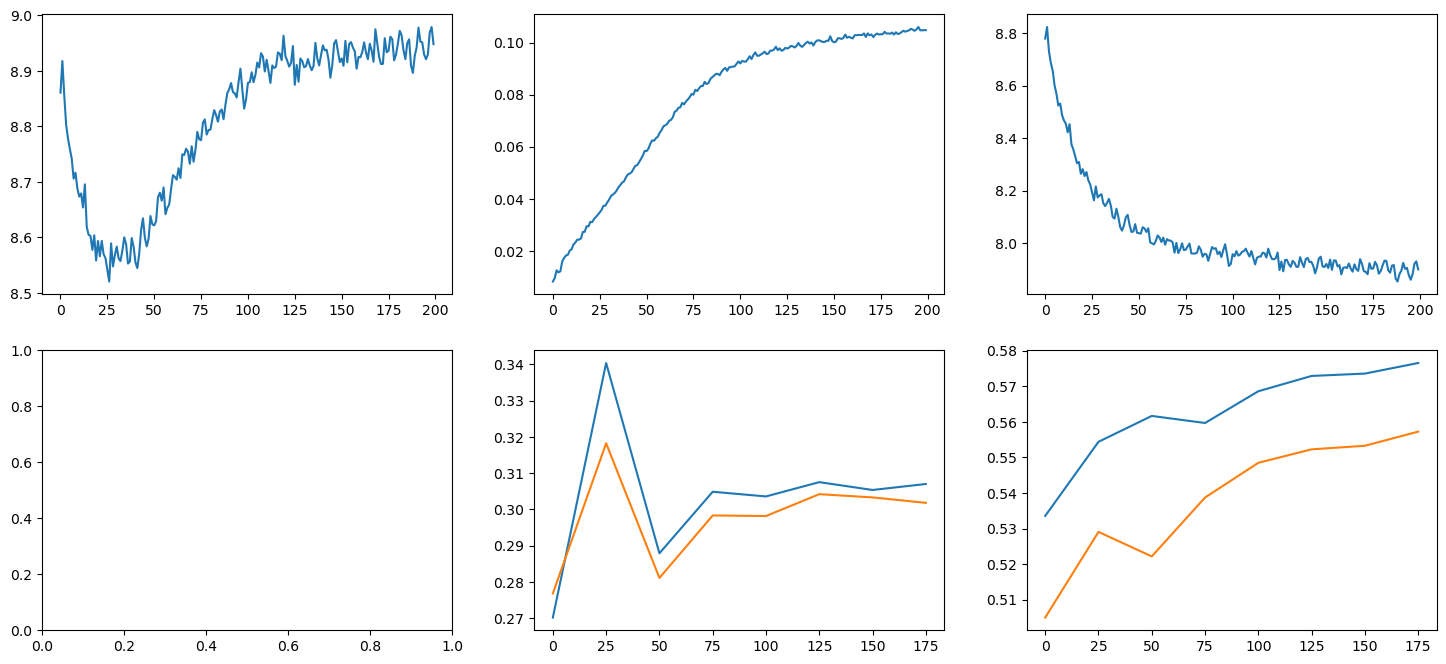

[MAX]ACC:  0.5765289256198347
[MAX]NMI:  0.3403774338777384
[MAX]ARI:  0.3182467148111896
[MAX]F1:  0.557243947041526


In [44]:
from GCL.models import DualBranchContrast


def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro

def train(encoder_model, contrast_model, optimizer, x, graph, edge_index):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, q = encoder_model(x, graph, edge_index)
    p = target_distribution(q.data)
    con_loss = contrast_model(z1, z2)

    kl_loss = F.kl_div(q.log(), p, reduction='batchmean')

    # con_loss = 0.01 * con_loss
    loss = (con_loss + 10 * kl_loss)

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), kl_loss.item()

aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])
aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])

#0.9
# aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])

#0.90
# aug1 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.3)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.3)])

# aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])

# aug1 = A.RandomChoice([A.RWSampling(num_seeds=1000, walk_length=10),
#                       A.NodeDropping(pn=0.1),
#                       A.FeatureMasking(pf=0.1),
#                       A.EdgeRemoving(pe=0.1)],
#                      num_choices=1)
# aug2 = A.RandomChoice([A.RWSampling(num_seeds=1000, walk_length=10),
#                       A.NodeDropping(pn=0.1),
#                       A.FeatureMasking(pf=0.1),
#                       A.EdgeRemoving(pe=0.1)],
#                      num_choices=1)

# encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=4, num_layers=2).to(device)
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=3, num_layers=4).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)

# contrast_model = WithinEmbedContrast(loss=L.VICReg()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.001)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs = 200

kmeans = KMeans(n_clusters=3, n_init=20)

with torch.no_grad():
    z, _, _, _ = encoder_model(x, graph, edge_index)
_ = kmeans.fit_predict(z.data.cpu().numpy())
encoder_model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph, edge_index)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _ = encoder_model(x, graph, edge_index)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


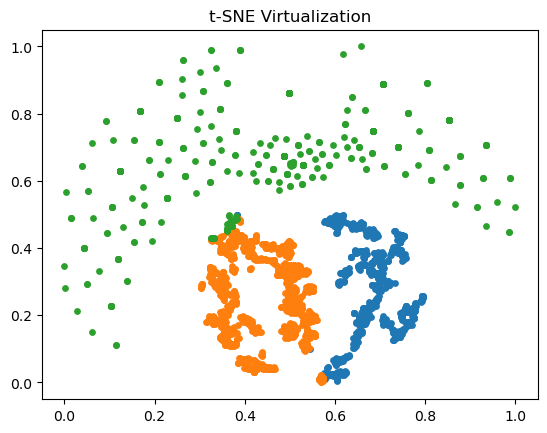

In [45]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _ = encoder_model(x, graph, edge_index)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [46]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, qs = encoder_model(x, graph, edge_index)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)




[INFO]NMI:  0.29977396576433457
[INFO]ARI:  0.2965995795738085


In [47]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

[INFO]NMI:  0.3253694359121433
[INFO]ARI:  0.30010896462778625


In [48]:


with torch.no_grad():
    encoder_model.eval()
    z, _, _, _ = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())
acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(acc, f1)

TypeError: forward() missing 1 required positional argument: 'edge_index'